In [14]:
import os
import sys
import copy
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

EPS = 1e-6

class VNLinear(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(VNLinear, self).__init__()
        self.map_to_feat = nn.Linear(in_channels, out_channels, bias=False)
    

    def forward(self, x):
        '''
        x: point features of shape [B, N_feat, 4, N_samples, ...]
        '''
        x_out = self.map_to_feat(x.transpose(1,-1)).transpose(1,-1)
        return x_out



class VNLeakyReLU(nn.Module):

    def __init__(self, in_channels, share_nonlinearity=False, negative_slope=0.2):
        super(VNLeakyReLU, self).__init__()
        if share_nonlinearity == True:
            self.map_to_dir = nn.Linear(in_channels, 1, bias=False)
        else:
            self.map_to_dir = nn.Linear(in_channels, in_channels, bias=False)
        self.negative_slope = negative_slope
        self.negative_slope = negative_slope
    

    def forward(self, x):
        '''
        x: point features of shape [B, N_feat, 3, N_samples, ...]
        '''
        d = self.map_to_dir(x.transpose(1,-1)).transpose(1,-1)
        dotprod = (x*d).sum(2, keepdim=True)
        mask = (dotprod >= 0).float()
        d_norm_sq = (d*d).sum(2, keepdim=True)
        x_out = self.negative_slope * x + (1-self.negative_slope) * (mask*x + (1-mask)*(x-(dotprod/(d_norm_sq+EPS))*d))
        x_out = self.negative_slope * x + (1-self.negative_slope) * (mask*x + (1-mask)*(x-(dotprod/(d_norm_sq+EPS))*d))
        return x_out



class VNLinearLeakyReLU(nn.Module): ########################################

    def __init__(self, in_channels, out_channels, dim=4, share_nonlinearity=False, negative_slope=0.2):
        super(VNLinearLeakyReLU, self).__init__()
        self.dim = dim
        self.negative_slope = negative_slope
        self.negative_slope = negative_slope
        
        self.map_to_feat = nn.Linear(in_channels, out_channels, bias=False)
        self.batchnorm = VNBatchNorm(out_channels, dim=dim)
        
        if share_nonlinearity == True:
            self.map_to_dir = nn.Linear(in_channels, 1, bias=False)
        else:
            self.map_to_dir = nn.Linear(in_channels, out_channels, bias=False)
    

    def forward(self, x):
        '''
        x: point features of shape [B, N_feat, 3, N_samples, ...]
        '''
        # Linear
        p = self.map_to_feat(x.transpose(1,-1)).transpose(1,-1)
        
        # BatchNorm
        p = self.batchnorm(p)
        # LeakyReLU
        d = self.map_to_dir(x.transpose(1,-1)).transpose(1,-1)
        dotprod = (p*d).sum(2, keepdims=True)
        mask = (dotprod >= 0).float()
        d_norm_sq = (d*d).sum(2, keepdims=True)
        x_out = self.negative_slope * p + (1-self.negative_slope) * (mask*p + (1-mask)*(p-(dotprod/(d_norm_sq+EPS))*d))
        x_out = self.negative_slope * p + (1-self.negative_slope) * (mask*p + (1-mask)*(p-(dotprod/(d_norm_sq+EPS))*d))
        return x_out



class VNLinearAndLeakyReLU(nn.Module):

    def __init__(self, in_channels, out_channels, dim=5, share_nonlinearity=False, use_batchnorm='norm', negative_slope=0.2):
        super(VNLinearLeakyReLU, self).__init__()
        self.dim = dim
        self.share_nonlinearity = share_nonlinearity
        self.use_batchnorm = use_batchnorm
        self.negative_slope = negative_slope
        self.negative_slope = negative_slope
        
        self.linear = VNLinear(in_channels, out_channels)
        self.leaky_relu = VNLeakyReLU(out_channels, share_nonlinearity=share_nonlinearity, negative_slope=negative_slope)
        self.leaky_relu = VNLeakyReLU(out_channels, share_nonlinearity=share_nonlinearity, negative_slope=negative_slope)
        
        # BatchNorm
        self.use_batchnorm = use_batchnorm
        if use_batchnorm != 'none':
            self.batchnorm = VNBatchNorm(out_channels, dim=dim, mode=use_batchnorm)
    

    def forward(self, x):
        '''
        x: point features of shape [B, N_feat, 3, N_samples, ...]
        '''
        # Conv
        x = self.linear(x)
        # InstanceNorm
        if self.use_batchnorm != 'none':
            x = self.batchnorm(x)
        # LeakyReLU
        x_out = self.leaky_relu(x)
        return x_out



class VNBatchNorm(nn.Module):

    def __init__(self, num_features, dim):
        super(VNBatchNorm, self).__init__()
        self.dim = dim
        if dim == 3 or dim == 4:
            self.bn = nn.BatchNorm1d(num_features)
        elif dim == 5:
            self.bn = nn.BatchNorm2d(num_features)
    

    def forward(self, x):
        '''
        x: point features of shape [B, N_feat, 3, N_samples, ...]
        '''
        # norm = torch.sqrt((x*x).sum(2))
        norm = torch.norm(x, dim=2) + EPS
        norm_bn = self.bn(norm)
        norm = norm.unsqueeze(2)
        norm_bn = norm_bn.unsqueeze(2)
        x = x / norm * norm_bn
        
        return x



class VNMaxPool(nn.Module):
    def __init__(self, in_channels):
        super(VNMaxPool, self).__init__()
        self.map_to_dir = nn.Linear(in_channels, in_channels, bias=False)
    

    def forward(self, x):
        '''
        x: point features of shape [B, N_feat, 3, N_samples, ...]
        '''
        d = self.map_to_dir(x.transpose(1,-1)).transpose(1,-1)
        dotprod = (x*d).sum(2, keepdims=True)
        idx = dotprod.max(dim=-1, keepdim=False)[1]
        index_tuple = torch.meshgrid([torch.arange(j) for j in x.size()[:-1]]) + (idx,)
        x_max = x[index_tuple]
        return x_max


def mean_pool(x, dim=-1, keepdim=False):
    return x.mean(dim=dim, keepdim=keepdim)



class VNStdFeature(nn.Module):

    def __init__(self, in_channels, dim=3, normalize_frame=False, share_nonlinearity=False, negative_slope=0.2):
        super(VNStdFeature, self).__init__()
        self.dim = dim
        self.normalize_frame = normalize_frame
        
        self.vn1 = VNLinearLeakyReLU(in_channels, in_channels//2, dim=dim, share_nonlinearity=share_nonlinearity, negative_slope=negative_slope)
        self.vn2 = VNLinearLeakyReLU(in_channels//2, in_channels//4, dim=dim, share_nonlinearity=share_nonlinearity, negative_slope=negative_slope)
        if normalize_frame:
            self.vn_lin = nn.Linear(in_channels//4, 2, bias=False)
        else:
            self.vn_lin = nn.Linear(in_channels//4, 3, bias=False)
    

    def forward(self, x):
        '''
        x: point features of shape [B, N_feat, 3, N_samples, ...]
        '''
        z0 = x
        z0 = self.vn1(z0)
        z0 = self.vn2(z0)
        z0 = self.vn_lin(z0.transpose(1, -1)).transpose(1, -1)

        
        if self.normalize_frame:
            # make z0 orthogonal. u2 = v2 - proj_u1(v2)
            v1 = z0[:,0,:]
            #u1 = F.normalize(v1, dim=1)
            v1_norm = torch.sqrt((v1*v1).sum(1, keepdims=True))
            u1 = v1 / (v1_norm+EPS)
            v2 = z0[:,1,:]
            v2 = v2 - (v2*u1).sum(1, keepdims=True)*u1
            #u2 = F.normalize(u2, dim=1)
            v2_norm = torch.sqrt((v2*v2).sum(1, keepdims=True))
            u2 = v2 / (v2_norm+EPS)

            # compute the cross product of the two output vectors        
            u3 = torch.cross(u1, u2)
            z0 = torch.stack([u1, u2, u3], dim=1).transpose(1, 2)
        else:
            z0 = z0.transpose(1, 2)
        if self.dim == 4:
            x_std = torch.einsum('bijm,bjkm->bikm', x, z0)
        elif self.dim == 3:
            x_std = torch.einsum('bij,bjk->bik', x, z0)
        elif self.dim == 5:
            x_std = torch.einsum('bijmn,bjkmn->bikmn', x, z0)
        
        return x_std, z0

In [16]:
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F



class get_model(nn.Module):

    def __init__(self, num_class=10, normal_channel=False):
        super(get_model, self).__init__()
        self.n_knn = 5 #args.n_knn
        
        self.conv1 = VNLinearLeakyReLU(1, 64//3)
        self.conv2 = VNLinearLeakyReLU(64//3, 64//3) 
        self.conv3 = VNLinearLeakyReLU(64//3, 128//3)
        self.conv4 = VNLinearLeakyReLU(128//3, 256//3)
        self.conv5 = VNLinearLeakyReLU(256//3+128//3+64//3+64//3, 1024//3, dim=4, share_nonlinearity=True)
        
        self.std_feature = VNStdFeature(1024//3*2, dim=3, normalize_frame=False)
        self.linear1 = nn.Linear((1024//3)*4, 512)
        
        self.bn1 = nn.BatchNorm1d(512)
        self.dp1 = nn.Dropout(p=0.5)
        self.linear2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dp2 = nn.Dropout(p=0.5)
        self.linear3 = nn.Linear(256, num_class)
        

        self.pool1 = VNMaxPool(64//3)
        self.pool2 = VNMaxPool(64//3)
        self.pool3 = VNMaxPool(128//3)
        self.pool4 = VNMaxPool(256//3)


    def forward(self, x):
        batch_size = x.size(0)
        #x = x.unsqueeze(1)
        x = self.conv1(x)
        x1 = self.pool1(x)
        
        x = self.conv2(x)
        x2 = self.pool2(x)
        
        x = self.conv3(x)
        x3 = self.pool3(x)
        
        x = self.conv4(x)
        x4 = self.pool4(x)
        
        x = torch.cat((x1, x2, x3, x4), dim=1)
        x = self.conv5(x)
        
        num_points = x.size(-1)
        x_mean = x.mean(dim=-1, keepdim=True).expand(x.size())
        x = torch.cat((x, x_mean), 1)
        x, trans = self.std_feature(x)
        #swap x with trans?
        #x = x.view(batch_size, -1, num_points)
        
        x1 = F.adaptive_max_pool1d(x, 1).view(batch_size, -1)
        x2 = F.adaptive_avg_pool1d(x, 1).view(batch_size, -1)
        x = torch.cat((x1, x2), 1)
        x = F.leaky_relu(self.bn1(self.linear1(x)), negative_slope=0.2)
        x = self.dp1(x)
        x = F.leaky_relu(self.bn2(self.linear2(x)), negative_slope=0.2)
        x = self.dp2(x)
        x = self.linear3(x)
        
        trans_feat = None
        return x, trans_feat



class get_loss(torch.nn.Module):
    def __init__(self):
        super(get_loss, self).__init__()


    def forward(self, pred, target, trans_feat, smoothing=True):
        ''' Calculate cross entropy loss, apply label smoothing if needed. '''

        target = target.contiguous().view(-1)

        if smoothing:
            eps = 0.2
            n_class = pred.size(1)

            one_hot = torch.zeros_like(pred).scatter(1, target.view(-1, 1), 1)
            one_hot = one_hot * (1 - eps) + (1 - one_hot) * eps / (n_class - 1)
            log_prb = F.log_softmax(pred, dim=1)

            loss = -(one_hot * log_prb).sum(dim=1).mean()
        else:
            loss = F.cross_entropy(pred, target, reduction='mean')
            
        return loss


In [17]:
classifier = get_model()
criterion = get_loss()
optimizer = torch.optim.SGD(
            classifier.parameters(),
            lr=0.01,
            momentum=0.9,
            weight_decay=1e-4
        )

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.7)
global_epoch = 0
global_step = 0
best_instance_acc = 0.0
best_class_acc = 0.0
mean_correct = []

In [18]:
class ToPC(object):

    def __call__(self, sample):
        ret = torch.tensor([[[i/sample.shape[1],j/sample.shape[2],sample[b][i][j]]for i in range(sample.shape[1])for j in range(sample.shape[2]) ]for b in range(sample.shape[0])])
        return ret

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images torch.Size([4, 1, 28, 28]) labels: tensor([7, 7, 4, 7])


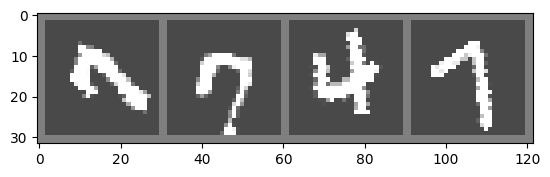

tensor([-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,  0.8868,
         2.8088,  2.8088,  2.0960, -0.2842, -0.4242, -0.4242, -0.4242, -0.4242,
        -0.2587,  0.6831,  2.8088,  2.8088,  2.1978, -0.0806, -0.4242, -0.4242,
        -0.4242, -0.4242, -0.4242, -0.4242])
images shape torch.Size([4, 1, 28, 28])


In [19]:
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np


data_path = '/Users/shizhehe/dev/research/vector_neurons_mri/vnn/data/'

trainloader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(data_path, train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.RandomRotation((-90,90)),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,)),
                               #ToPC(),
                             ])),
  batch_size=4, shuffle=True)

testloader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(data_path, train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=1, shuffle=True)


dataiter = iter(trainloader)
images, labels = next(dataiter)
print ("images", images.shape, "labels:", labels)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
imshow(torchvision.utils.make_grid(images))
print(images[0][0][15])

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
print("images shape", images.shape)

In [20]:
from random import randrange
from math import sin, cos
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
       
        outputs,feats = classifier(inputs)       
        loss = criterion(outputs, labels, feats)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 0:    # print every 200 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            print(outputs)
            running_loss = 0.0

print('Finished Training')

/Users/shizhehe/miniforge3/envs/torch_39/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[1,     1] loss: 0.001
tensor([[ 0.0930,  0.6578,  0.4070, -0.7925, -0.1593,  0.4478, -0.0058,  0.3127,
         -1.1603,  0.0383],
        [-0.5797,  0.1586,  1.2050, -0.5811, -0.0598, -0.1296, -0.2231, -0.5745,
         -0.3393,  0.3959],
        [-0.2604, -0.4528,  0.7929,  0.6641, -0.1831,  0.1431, -0.0578, -0.5900,
         -0.5844,  0.2253],
        [-0.0585, -0.6713, -0.4912, -0.8367,  0.2840, -0.0873, -0.6732, -0.1199,
         -0.1870,  0.3821]], grad_fn=<AddmmBackward0>)
[1,   201] loss: 0.319
tensor([[ 6.9904e-01, -4.2545e-01,  3.6281e+00, -1.5941e+00,  1.3703e+00,
         -1.6770e+00,  4.1929e+00, -4.6762e+00, -1.5416e+00,  8.8420e-01],
        [-5.9139e-01,  7.3088e-01, -6.2093e-01,  5.6334e-01,  9.4728e-01,
          2.2435e-01, -2.8742e+00,  1.2681e+00, -1.5597e-01,  3.5418e-01],
        [ 4.7354e-01, -9.4560e-01,  5.0188e-01,  3.5047e-01,  1.1118e+00,
          5.5110e-01, -2.1418e+00,  3.4785e-03, -8.8992e-01,  3.1104e-01],
        [ 3.0111e-01,  1.2587e+00, -9.6170e-

In [ ]:
from pytorch3d.transforms import RotateAxisAngle, Rotate, random_rotations
x = torch.rand(10,40,3)
emb ,feat = classifier(x)
trot = RotateAxisAngle(angle=90, axis="Z", degrees=True)
x2 = trot.transform_points(x)
emb2 ,feat = classifier(x2)
inemb1 = trot.transform_points(emb)
print (emb2-inemb1)
print(emb2)

In [ ]:
from pytorch3d.transforms import RotateAxisAngle, Rotate, random_rotations

rot = 'so3'
num_epochs = 2

for epoch in range(num_epochs):
        print('Epoch %d (%d/%s):' % (global_epoch + 1, epoch + 1, args.epoch))

        scheduler.step()
        for batch_id, data in tqdm(enumerate(trainDataLoader, 0), total=len(trainDataLoader), smoothing=0.9):
            points, target = data
            
            trot = None
            if rot == 'z':
                trot = RotateAxisAngle(angle=torch.rand(points.shape[0])*360, axis="Z", degrees=True)
                trot = RotateAxisAngle(angle=torch.rand(points.shape[0])*360, axis="Z", degrees=True)
            elif rot == 'so3':
                trot = Rotate(R=random_rotations(points.shape[0]))
                trot = Rotate(R=random_rotations(points.shape[0]))
            if trot is not None:
                points = trot.transform_points(points)
            
            points = points.data.numpy()
            points = provider.random_point_dropout(points)
            points[:,:, 0:3] = provider.random_scale_point_cloud(points[:,:, 0:3])
            points[:,:, 0:3] = provider.shift_point_cloud(points[:,:, 0:3])
            points = torch.Tensor(points)
            target = target[:, 0]

            points = points.transpose(2, 1)
            points, target = points.cuda(), target.cuda()
            optimizer.zero_grad()

            classifier = classifier.train()
            pred, trans_feat = classifier(points)
            loss = criterion(pred, target.long(), trans_feat)
            pred_choice = pred.data.max(1)[1]
            correct = pred_choice.eq(target.long().data).cpu().sum()
            mean_correct.append(correct.item() / float(points.size()[0]))
            loss.backward()
            optimizer.step()
            global_step += 1

        train_instance_acc = np.mean(mean_correct)
        print('Train Instance Accuracy: %f' % train_instance_acc)


        with torch.no_grad():
            instance_acc, class_acc = test(classifier.eval(), testDataLoader)

            if (instance_acc >= best_instance_acc):
                best_instance_acc = instance_acc
                best_epoch = epoch + 1

            if (class_acc >= best_class_acc):
                best_class_acc = class_acc
            log_string('Test Instance Accuracy: %f, Class Accuracy: %f'% (instance_acc, class_acc))
            log_string('Best Instance Accuracy: %f, Class Accuracy: %f'% (best_instance_acc, best_class_acc))

            if (instance_acc >= best_instance_acc):
                logger.info('Save model...')
                savepath = str(checkpoints_dir) + '/best_model.pth'
                log_string('Saving at %s'% savepath)
                state = {
                    'epoch': best_epoch,
                    'instance_acc': instance_acc,
                    'class_acc': class_acc,
                    'model_state_dict': classifier.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                }
                torch.save(state, savepath)
            global_epoch += 1
